In [1]:
%matplotlib inline
import re
import sys
import math
import matplotlib
import seaborn
import numpy
from matplotlib import pyplot as plt
from collections import defaultdict

from evalutils import IntervalForest, populate_index_from_bed, compact
from evalutils import subset_variants_bed, load_kevlar_vcf, load_scalpel_vcf, load_discosnp_vcf, load_gatk_mvf, load_triodenovo_vcf
import kevlar

seaborn.set_context({'figure.figsize': (22, 11)})
matplotlib.rcParams['axes.labelsize'] = 16
matplotlib.rcParams['xtick.labelsize'] = 14
matplotlib.rcParams['ytick.labelsize'] = 14

In [2]:
def roc(calls, index, delta=10, fmt='vcf'):
    ncorrect = 0
    num_true_calls_per_false_call = list()
    for varcall in calls:
        if fmt == 'vcf':
            valid = index.query(varcall.seqid, varcall.position, delta=delta) != set()
        elif fmt == 'mvf':
            callindex, call = varcall
            valid = index.query(call['CHROM'], call['POS'], delta=delta) != set()
        else:
            raise ValueError('unknown format "'+ fmt +'"')
        if valid:
            ncorrect += 1
            continue
        num_true_calls_per_false_call.append(ncorrect)
    if len(num_true_calls_per_false_call) == 0 or ncorrect > num_true_calls_per_false_call[-1]:
        num_true_calls_per_false_call.append(ncorrect)
    return num_true_calls_per_false_call

In [43]:
def doplot(axis, data, color, label, linestyle, symbol, msize, xmax):
    axis.plot(range(len(data))[-1], data[-1], symbol, markersize=msize, color=color)
    axis.plot(range(len(data)), data, color=color, linestyle=linestyle, label=label)
    #base = 30 if xmax > 200 else 10
    #rate = max(base * len(data) / xmax, 1)
    if xmax < 10:
        #rate = 1
        axis.plot(range(len(data)), data, symbol, markersize=msize, color=color, markevery=1, label=label)

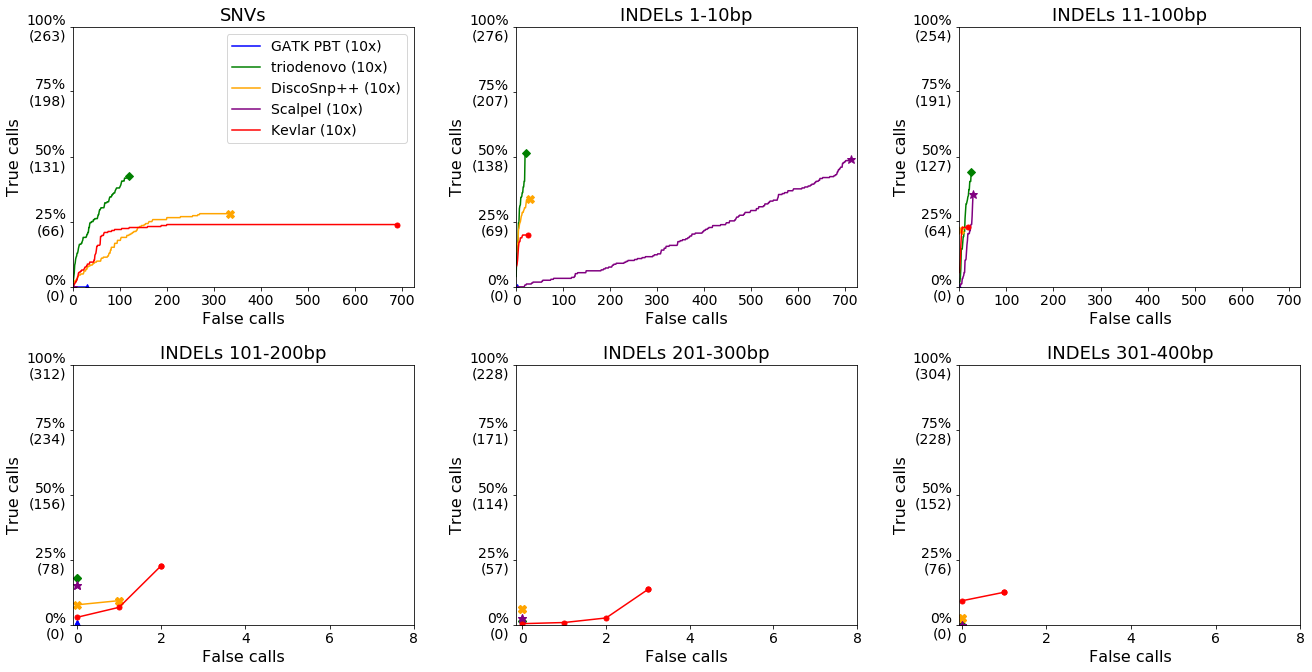

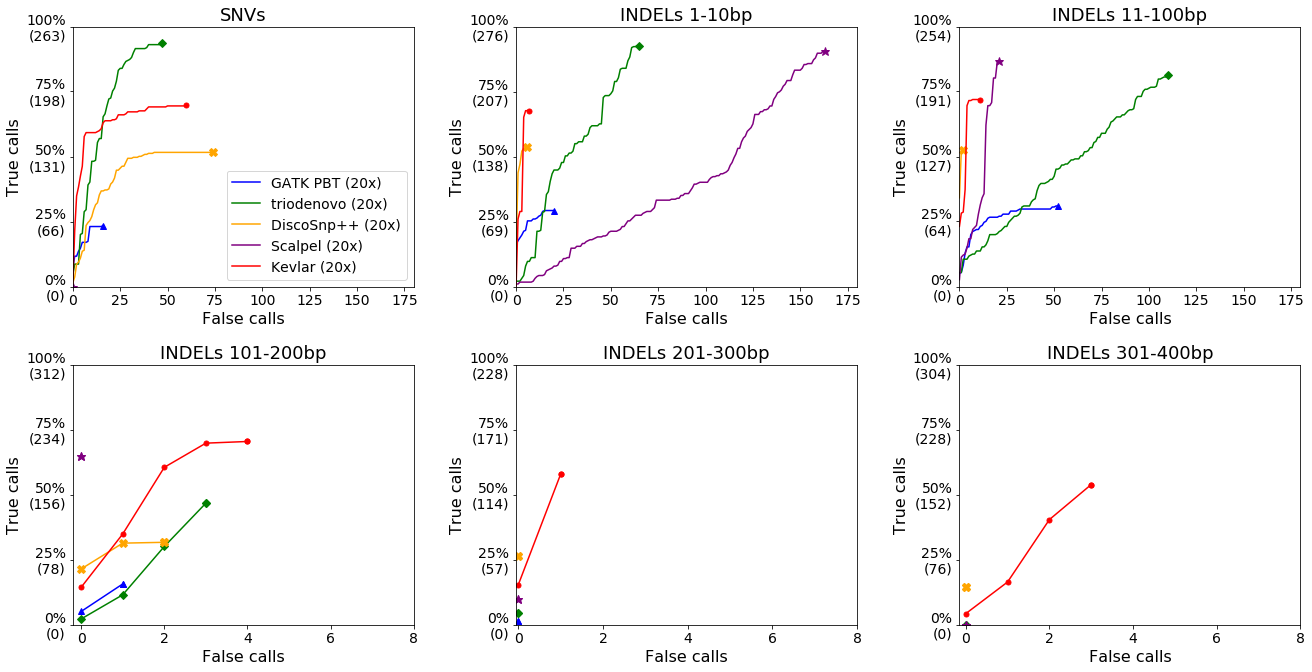

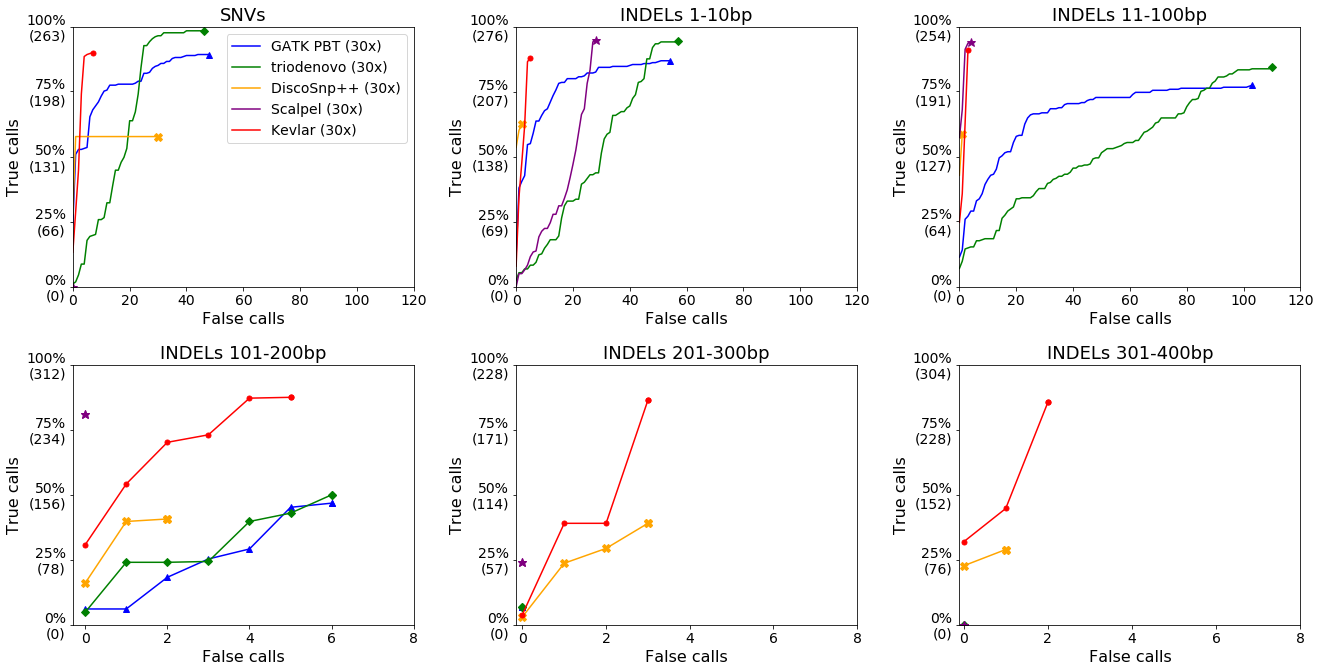

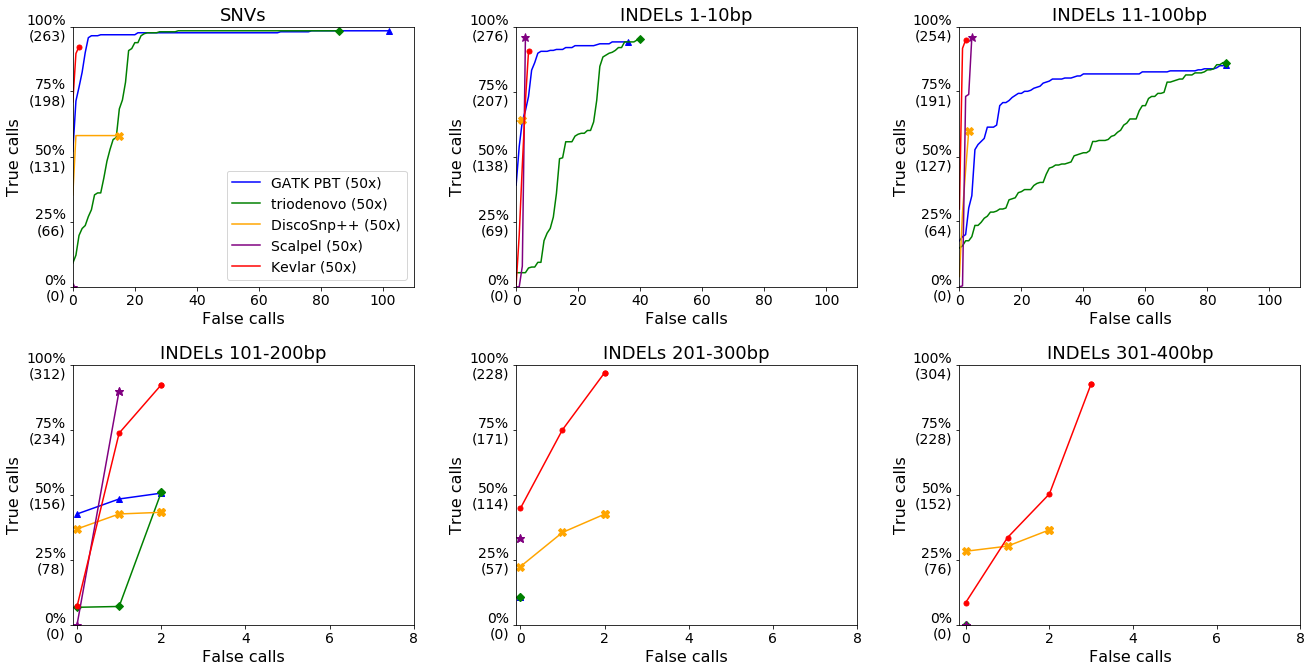

In [44]:
delta = 10
linestyle = '-'
coverage = ('10', '20', '30', '50')
legend_placement = (1, 4, 1, 4)
xmaxes = (725, 180, 120, 110)
#coverage = ['30']
#legend_placement = [1]
#xmaxes = [120]
for cov, legloc, xmax in zip(coverage, legend_placement, xmaxes):
    seaborn.set_context({'figure.figsize': (22, 11)})
    matplotlib.rcParams['axes.labelsize'] = 16
    matplotlib.rcParams['xtick.labelsize'] = 14
    matplotlib.rcParams['ytick.labelsize'] = 14
    
    categories = [
        ('SNV', None, None, 'SNVs'),
        ('INDEL', 1, 10, 'INDELs 1-10bp'),
        ('INDEL', 11, 100, 'INDELs 11-100bp'),
        ('INDEL', 101, 200, 'INDELs 101-200bp'),
        ('INDEL', 201, 300, 'INDELs 201-300bp'),
        ('INDEL', 301, 400, 'INDELs 301-400bp'),
    ]
    fig, ((ax11, ax12, ax13), (ax21, ax22, ax23)) = plt.subplots(2, 3)
    axes = (ax11, ax12, ax13, ax21, ax22, ax23)
    seaborn.set_context({'figure.figsize': (24, 12)})
    
    for i, (category, axis) in enumerate(zip(categories, axes)):
        vartype, minlength, maxlength, label = category
        with kevlar.open('SimulatedVariants_chr17_hg38_markII.bed', 'r') as instream:
            variants = subset_variants_bed(instream, vartype, minlength, maxlength)
            index = populate_index_from_bed(variants)
        
            kevlar_truecalls = roc(
                load_kevlar_vcf(
                    'kevlar-calls-'+ cov +'x-nohomopoly.vcf.gz', index, delta=delta,
                    vartype=vartype, minlength=minlength, maxlength=maxlength
                ),
                index, delta=delta, fmt='vcf'
            )
            scalpel_truecalls = roc(
                load_scalpel_vcf(
                    'scalpel.'+ cov +'x.denovo.indel.vcf', cov=cov,
                    vartype=vartype, minlength=minlength, maxlength=maxlength,
                ),
                index, delta=delta, fmt='vcf'
            )
            discosnp_truecalls = roc(
                load_discosnp_vcf(
                    'discosnp.'+ cov +'x.vcf.gz', cov=cov, applyfilters=False,
                    vartype=vartype, minlength=minlength, maxlength=maxlength,
                ),
                index, delta=delta, fmt='vcf'
            )
            gatk_truecalls = roc(
                load_gatk_mvf(
                    'JointCall-'+ cov +'x-PBT.mvf',
                    vartype=vartype, minlength=minlength, maxlength=maxlength
                ).iterrows(),
                index, delta=delta, fmt='mvf'
            )
            triodenovo_truecalls = roc(
                load_triodenovo_vcf(
                    'JointCall-'+ cov +'x-TDN.vcf', cov=cov,
                    vartype=vartype, minlength=minlength, maxlength=maxlength,
                ),
                index, delta=delta, fmt='vcf'
            )
            
            if i > 2:
                xmax = 8
            
            # doplot(axis, gatk_truecalls, 'blue', 'GATK PBT ({}x)'.format(cov), linestyle, '^', 3, xmax)
            # doplot(axis, triodenovo_truecalls, 'green', 'triodenovo ({}x)'.format(cov), linestyle, 'D', 3, xmax)
            # doplot(axis, discosnp_truecalls, 'orange', 'DiscoSnp++ ({}x)'.format(cov), linestyle, 'X', 4, xmax)
            # doplot(axis, scalpel_truecalls, 'purple', 'Scalpel ({}x)'.format(cov), linestyle, '*', 4, xmax)
            # doplot(axis, kevlar_truecalls, 'red', 'Kevlar ({}x)'.format(cov), linestyle, 'o', 3, xmax)
            
            doplot(axis, gatk_truecalls, 'blue', 'GATK PBT ({}x)'.format(cov), linestyle, '^', 6, xmax)
            doplot(axis, triodenovo_truecalls, 'green', 'triodenovo ({}x)'.format(cov), linestyle, 'D', 5, xmax)
            doplot(axis, discosnp_truecalls, 'orange', 'DiscoSnp++ ({}x)'.format(cov), linestyle, 'X', 8, xmax)
            doplot(axis, scalpel_truecalls, 'purple', 'Scalpel ({}x)'.format(cov), linestyle, '*', 9, xmax)
            doplot(axis, kevlar_truecalls, 'red', 'Kevlar ({}x)'.format(cov), linestyle, 'o', 5, xmax)
            
            nvariants = len(index.trees['chr17'])
            ticknums = [0, math.ceil(nvariants * 0.25), int(nvariants * 0.5), math.ceil(nvariants * 0.75), nvariants]
            ticklabels = ['{:d}%\n({:d})'.format(round(tn / nvariants * 100), tn) for tn in ticknums]
            
            _ = axis.set_xlabel('False calls', fontsize=16)
            # xaxis_max = max([len(kevlar_truecalls), len(scalpel_truecalls), len(gatk_truecalls), len(triodenovo_truecalls)])
            # if xaxis_max < 6:
            #    xticknums = list(range(xaxis_max))
            #    _ = axis.set_xticks(xticknums)
            if i > 2:
                _ = axis.set_xticks(list(range(0, 9, 2)))
            else:
                _ = axis.set_xlim((0, xmax))
            _ = axis.set_yticks(ticknums)
            _ = axis.set_yticklabels(ticklabels)
            _ = axis.set_ylabel('True calls', fontsize=16)
            _ = axis.set_ylim((0, nvariants))
            _ = axis.set_title(label, fontsize=18)
            if i == 0:
                _ = axis.legend(fontsize=14, loc=legloc)
    
    _ = plt.subplots_adjust(hspace=0.3, wspace=0.3)
    _ = plt.savefig('five-callers-'+ cov +'x-combined-sep.pdf', dpi=300)
    _ = plt.show()